In [29]:
%cd ..
import os
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.linear import Linear
from src.loss import *
from src.activation import TanH, Sigmoid, Softmax, ReLU, Softplus
from src.encapsulation import Sequential, Optim
np.random.seed(42)

/


In [2]:
batch_size = 8
X, y = load_digits(return_X_y=True, n_class=2)
y_oh = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()

net = Sequential(
    Linear(64, 32),
    TanH(),
    Linear(32, 16),
    TanH(),
    Linear(16, 8),
    TanH(),
    Linear(8, 2),
    Sigmoid(),
    # Softmax(),
)


100%|██████████| 50/50 [00:00<00:00, 135.66it/s]


1.0


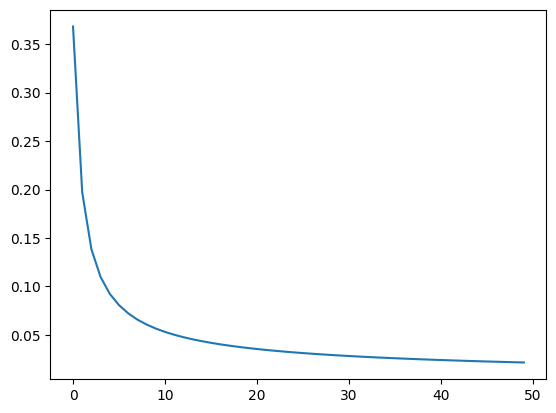

In [3]:
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-2)
lossList = optimizer.SGD(X, y_oh, batch_size, 50)
pd.Series(lossList).plot()
print(optimizer.score(X, y))


100%|██████████| 50/50 [00:00<00:00, 185.25it/s]


<Axes: xlabel='epoch', ylabel='loss'>

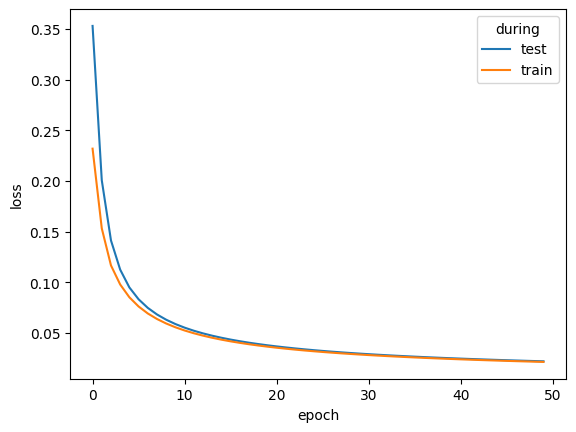

In [4]:
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-2)
result_df = optimizer.SGD_eval(
    X, y_oh, batch_size, 50, test_size=8, return_dataframe=True
)
loss_long_df = pd.melt(
    result_df,
    id_vars="epoch",
    value_vars=["loss_test", "loss_train"],
    value_name="loss",
    var_name="during",
).replace({"loss_test": "test", "loss_train": "train"})
sns.lineplot(loss_long_df, x="epoch", y="loss", hue="during")


0.3861111111111111


100%|██████████| 100/100 [00:00<00:00, 143.88it/s]


0    0.375
1    0.375
2    0.375
3    0.375
4    0.375
Name: score_test, dtype: float64

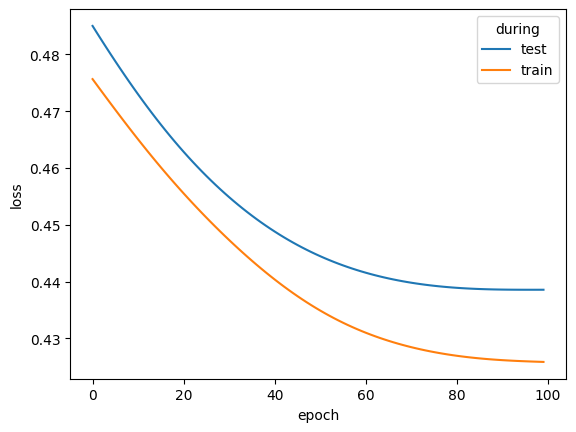

In [7]:
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-5)
print(optimizer.score(X, y))
result_df = optimizer.SGD_eval(X, y_oh, batch_size, 100, test_size=8, return_dataframe=True)
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during')
result_df['score_test'].head()

In [ ]:
result_df

,epoch,loss_test,loss_train,score_train,score_test
0,0,0.011989,0.012073,1.0,1.0
1,1,0.011948,0.012031,1.0,1.0
2,2,0.011907,0.011990,1.0,1.0
3,3,0.011866,0.011948,1.0,1.0
4,4,0.011826,0.011907,1.0,1.0
5,5,0.011786,0.011867,1.0,1.0
6,6,0.011747,0.011827,1.0,1.0
7,7,0.011708,0.011787,1.0,1.0
8,8,0.011670,0.011748,1.0,1.0
9,9,0.011631,0.011709,1.0,1.0


# Fashion MNIST

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try.  "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."

Zalando seeks to replace the original MNIST dataset

Data Description
* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.
* Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.
* The training and test data sets have 785 columns.
* The first column consists of the class labels (see above), and represents the article of clothing.
* The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix. For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide

In [7]:
def load_data(rootdir, trim: float = 0.5):
    train = pd.read_csv(os.path.join(rootdir, "fashion-mnist_train.csv"))
    y_train = train['label'].values
    X_train = train.drop(columns='label').values
    
    test = pd.read_csv(os.path.join(rootdir, "fashion-mnist_test.csv"))
    y_test = test['label'].values
    X_test = test.drop(columns='label').values
    
    trim_train = int(len(X_train) * trim)
    trim_test = int(len(X_test) * trim)
    return X_train[:trim_train, :], X_test[:trim_test, :], y_train[:trim_train], y_test[:trim_test]
rootdir = "./data/fashion-mnist/"
X_train, X_test, y_train, y_test = load_data(rootdir)

y_train_oh = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
nb_class = y_train_oh.shape[1]
batch_size = 64

100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


<Axes: xlabel='epoch', ylabel='score'>

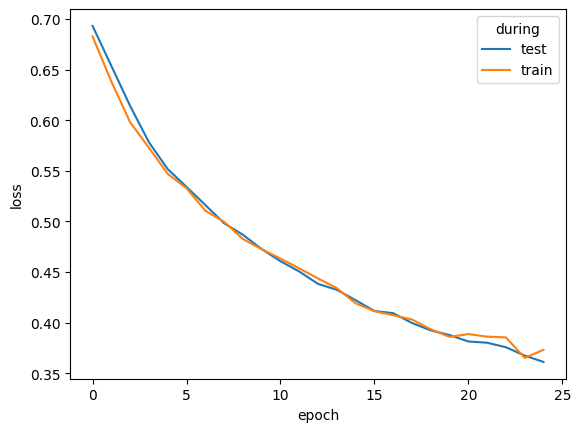

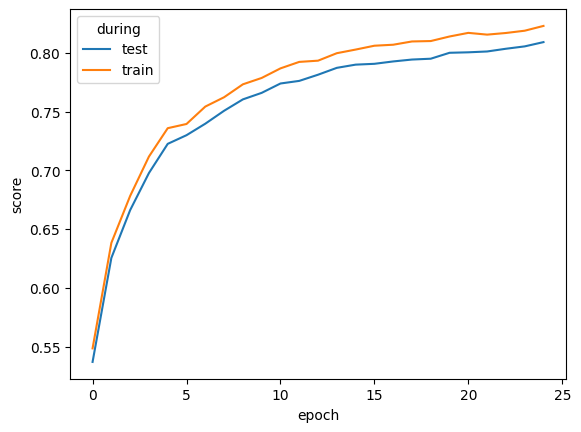

In [24]:
net = Sequential(
    Linear(784, 256),
    TanH(),
    Linear(256, 32),
    TanH(),
    Linear(32, nb_class),
    Sigmoid(),
)

optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-4)
result_df = optimizer.SGD_eval(X_train, y_train_oh, batch_size, 25, test_size=0.33, return_dataframe=True)

_, ax = plt.subplots()
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax)

_, ax = plt.subplots()
score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax)

Avec un softmax à la fin 

100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


<Axes: xlabel='epoch', ylabel='score'>

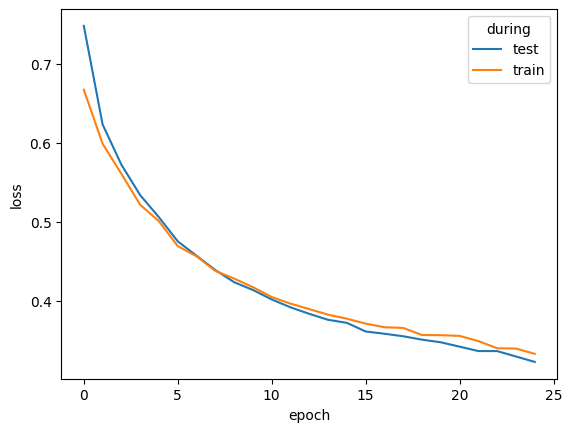

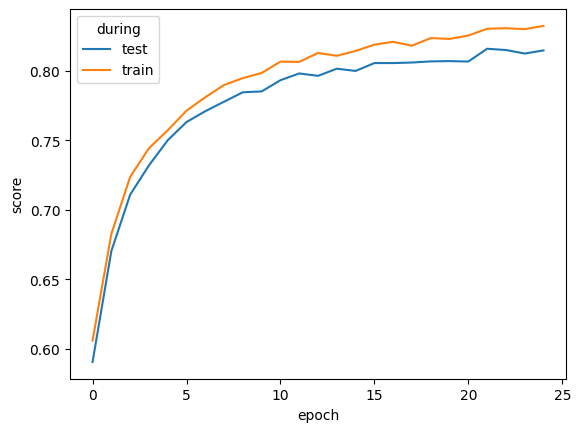

In [31]:
net = Sequential(
    Linear(784, 256),
    TanH(),
    Linear(256, 32),
    TanH(),
    Linear(32, nb_class),
    Softmax(),
)

optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=1e-4)
result_df = optimizer.SGD_eval(X_train, y_train_oh, batch_size, 25, test_size=0.33, return_dataframe=True)

_, ax = plt.subplots()
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax)

_, ax = plt.subplots()
score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax)

Avec des ReLUs

 16%|█▌        | 4/25 [00:11<00:57,  2.72s/it]/mnt/48566869-e5b1-482e-907d-2c513d1afe25/Documents/NeuralNetworksDIY/src/activation.py:44: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))
100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


<Axes: xlabel='epoch', ylabel='score'>

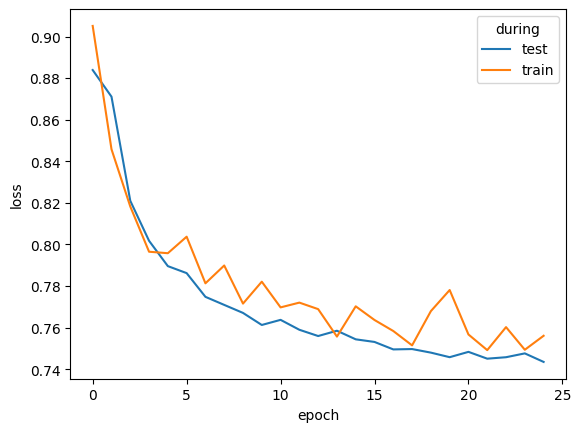

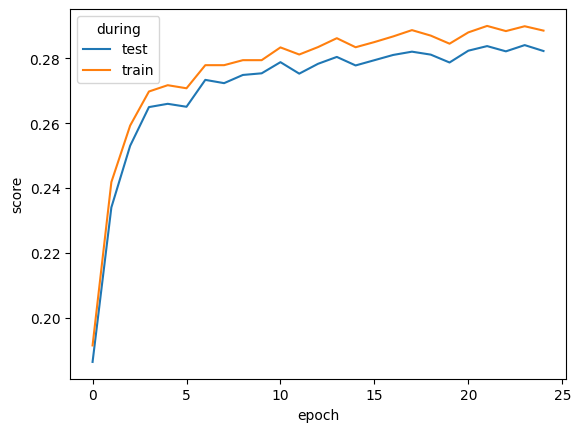

In [35]:
net = Sequential(
    Linear(784, 256),
    ReLU(),
    Linear(256, 32),
    ReLU(),
    Linear(32, nb_class),
    Sigmoid(),
)
optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=2e-5)
result_df = optimizer.SGD_eval(X_train, y_train_oh, batch_size, 25, test_size=0.33, return_dataframe=True)

_, ax = plt.subplots()
loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax)

_, ax = plt.subplots()
score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax)

fonctionne très mal